# Development of a support vector machine model for combining multiple deep learning models for detection and severity of Covid-19
Christian SOLIS CALERO

###Inicializando y Cargando la data

In [ ]:
# Cargar el Drive helper y mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Capacitaciones/Diplomado-Machine_learning-SARS-Cov2/Proyecto_deep_learning/Covid_Data_GradientCrescent/PA_DL_models

/content/drive/MyDrive/Capacitaciones/Diplomado-Machine_learning-SARS-Cov2/Proyecto_deep_learning/Covid_Data_GradientCrescent/PA_DL_models


## Evaluating obtained models in a new dataset

In [ ]:
%cd /content/drive/MyDrive/Capacitaciones/Diplomado-Machine_learning-SARS-Cov2/Proyecto_deep_learning/Covid_Data_GradientCrescent

/content/drive/MyDrive/Capacitaciones/Diplomado-Machine_learning-SARS-Cov2/Proyecto_deep_learning/Covid_Data_GradientCrescent


In [ ]:
!ls *_Epochs.h5 > modelos_Epochs.txt

Upload the models

In [ ]:
!cat modelos_Epochs.txt

Covid_PA_DenseNet121_Epochs.h5
Covid_PA_InceptionV3_Epochs.h5
Covid_PA_resnet50_Epochs.h5
Covid_PA_vgg16_Epochs.h5
Covid_PA_Xception_Epochs.h5


In [ ]:
models_files = []
with open('modelos_Epochs.txt') as inputfile:
    for line in inputfile:
        models_files.append(line.strip())

In [ ]:
from keras.models import load_model
models= []
[models.append(load_model(i)) for i in models_files]

[None, None, None, None, None]

In [ ]:
#Obtainig a list with the names of models
import re
name_models=[]
for k in models_files:
  name_models.append(re.sub(r'Covid_PA_', '',re.sub(r'_Epochs.h5', '', k)))

In [ ]:
name_models

['DenseNet121', 'InceptionV3', 'resnet50', 'vgg16', 'Xception']

In [ ]:
models[1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________


Updating the libraries

In [ ]:
import tensorflow as tf
from numpy.random import seed
seed(8) #1
tf.random.set_seed(7) 

import numpy as np 
import pandas as pd

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

Upadating the datasets

In [ ]:
from os import listdir
data_list = listdir('../twoF/train')

In [ ]:
DATASET_PATH  = '../twoF/train'
test_dir =  '../twoF/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE =0.0005 #start off with high rate first 0.001 #5e-4

#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary",
                                                 
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary",
                                                  )

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 608 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


## Testing the dataset using several binary classification models

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,

        class_mode="binary")
eval_generator.reset()    

In [ ]:
#x_list=[]
Test_loss =[]
Test_accuracy=[]
for i in range(len(models)):
  eval_generator.reset()  
  x_list = models[i].evaluate(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )
  Test_loss.append(x_list[0])
  Test_accuracy.append(x_list[1])

33/33 [==============================] - 5s 122ms/step - loss: 0.0144 - acc: 1.0000


In [ ]:
del list

In [ ]:
df_modelos = pd.DataFrame(list(zip(name_models, Test_loss,Test_accuracy)),
                          columns =['Model', 'Loss', 'Accuracy'])

In [ ]:
df_modelos

,Model,Loss,Accuracy
0,DenseNet121,0.385690,0.878788
1,InceptionV3,0.141162,0.939394
2,resnet50,0.130665,0.969697
3,vgg16,0.453235,0.787879
4,Xception,0.014440,1.000000


In [ ]:
predicciones=[]
for i in range(len(models)):
  eval_generator.reset()  
  pred = models[i].predict_generator(eval_generator,330,verbose=1)
  predicciones.append(pred)
print("Predictions finished")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


330/330 [==============================] - 45s 134ms/step
Predictions finished


In [ ]:
#Generando una lista con las etiquetas de las imagenes
labels=[]
regex = re.compile('\/')
import cv2
for index, probability in enumerate(predicciones[0]):
    labels.append(regex.split(eval_generator.filenames[index])[0])

In [ ]:
df_predicciones = pd.DataFrame(labels,columns =['Label'])

In [ ]:
lista_modelos=[]
for j in predicciones:
  lista_modelos.append([i[0] for i in j.tolist()])

In [ ]:
import numpy as np
lista_modelosF=np.array(lista_modelos).T.tolist()
df_predicciones= pd.DataFrame(lista_modelosF,columns =name_models)
df_predicciones['Label'] = labels
df_predicciones

,DenseNet121,InceptionV3,resnet50,vgg16,Xception,Label
0,0.000013,0.000681,0.009078,0.000175,4.931355e-05,covid
1,0.000031,0.006963,0.043851,0.013588,1.542141e-05,covid
2,0.001929,0.002591,0.382733,0.019397,4.594828e-05,covid
3,0.003868,0.048922,0.016421,0.002246,6.739527e-03,covid
4,0.000025,0.021827,0.006068,0.003772,5.382893e-07,covid
...,...,...,...,...,...,...
325,0.999939,0.999484,0.948295,0.999912,9.999070e-01,normal
326,0.999855,0.999998,0.981115,0.999995,9.999791e-01,normal
327,0.999924,1.000000,0.963362,0.999997,9.999991e-01,normal
328,0.999986,1.000000,0.959987,0.999993,9.999997e-01,normal


In [ ]:
df_prediccionesF=df_predicciones.iloc[:, 0:5].apply(lambda x: 1-x, axis=1)
df_prediccionesF["label"]=df_predicciones.iloc[:, 5].apply(lambda x : 1 if (x =="covid") else 0)

In [ ]:
df_prediccionesF

,DenseNet121,InceptionV3,resnet50,vgg16,Xception,label
0,0.999987,0.999319,0.990922,0.999825,9.999507e-01,1
1,0.999969,0.993037,0.956149,0.986412,9.999846e-01,1
2,0.998071,0.997409,0.617267,0.980603,9.999541e-01,1
3,0.996132,0.951078,0.983579,0.997754,9.932605e-01,1
4,0.999975,0.978173,0.993932,0.996228,9.999995e-01,1
...,...,...,...,...,...,...
325,0.000061,0.000516,0.051705,0.000088,9.298325e-05,0
326,0.000145,0.000002,0.018885,0.000005,2.086163e-05,0
327,0.000076,0.000000,0.036638,0.000003,8.940697e-07,0
328,0.000014,0.000000,0.040013,0.000007,2.980232e-07,0


In [ ]:
#adding the names of files
import re
archivos=[i.replace('covid\/','') for i in eval_generator.filenames]

In [ ]:
df_predicciones_archivos=df_prediccionesF
df_predicciones_archivos["Name_files"]=archivos
df_predicciones_archivos

,DenseNet121,InceptionV3,resnet50,vgg16,Xception,label,Name_files
0,0.999987,0.999319,0.990922,0.999825,9.999507e-01,1,covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
1,0.999969,0.993037,0.956149,0.986412,9.999846e-01,1,covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg
2,0.998071,0.997409,0.617267,0.980603,9.999541e-01,1,covid/1.CXRCTThoraximagesofCOVID-19fromSingapo...
3,0.996132,0.951078,0.983579,0.997754,9.932605e-01,1,covid/1.CXRCTThoraximagesofCOVID-19fromSingapo...
4,0.999975,0.978173,0.993932,0.996228,9.999995e-01,1,covid/16660_3_1.jpg
...,...,...,...,...,...,...,...
325,0.000061,0.000516,0.051705,0.000088,9.298325e-05,0,normal/NORMAL2-IM-0983-0001.jpeg
326,0.000145,0.000002,0.018885,0.000005,2.086163e-05,0,normal/NORMAL2-IM-0986-0001.jpeg
327,0.000076,0.000000,0.036638,0.000003,8.940697e-07,0,normal/NORMAL2-IM-0987-0001.jpeg
328,0.000014,0.000000,0.040013,0.000007,2.980232e-07,0,normal/NORMAL2-IM-0989-0001.jpeg


In [ ]:
# Guardar datos de las probabilidades
df_predicciones_archivos.to_csv('Models_PA_results_probabilities_Selected_Interval.csv', index=False)

## Analisis de los resultados de los modelos

__Reporte de clasificación y Matrices de confusión__

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

In [ ]:
regex2 = re.compile('\_')

In [ ]:
cf_matrix=[]
especificidad=[]
sensibilidad=[]
exactitud=[]
puntajeF1=[]
Precision=[]

target_names = ['covid', 'normal']
for i in range(len(models)):
  resultados=list(df_predicciones.iloc[:, i].apply(lambda x: "normal" if (x > 0.5) else "covid"))
  cf_matrix.append(confusion_matrix(labels, resultados))
  print(colored(name_models[i], attrs=['bold']))
  print(classification_report(labels, resultados, target_names=target_names))

  tn, fp, fn, tp = confusion_matrix(labels, resultados).ravel()
  specificity = tn / (tn+fp)
  especificidad.append(specificity)
  print("Specificity: ",specificity)
  print("")
  sensivity = tp / (tp+fn)
  sensibilidad.append(sensivity)
  print("Sensivity: ",sensivity)
  print("")
  accuracyT = (tp+tn)/ (tn+fp+fn+tp)
  exactitud.append(accuracyT)
  print("Accuracy: ",accuracyT)
  print("")
  F1score = 2*tp/ (2*tp+fp+fn)
  puntajeF1.append(F1score)
  print("F1 score: ",F1score)
  print("")
  precision = tp/ (tp+fp)
  Precision.append(precision)
  print("Precision (PPV): ",precision)
  print("")

DenseNet121
              precision    recall  f1-score   support

       covid       1.00      0.88      0.94        86
      normal       0.96      1.00      0.98       244

    accuracy                           0.97       330
   macro avg       0.98      0.94      0.96       330
weighted avg       0.97      0.97      0.97       330

Specificity:  0.8837209302325582

Sensivity:  1.0

Accuracy:  0.9696969696969697

F1 score:  0.9799196787148594

Precision (PPV):  0.9606299212598425

InceptionV3
              precision    recall  f1-score   support

       covid       0.99      0.98      0.98        86
      normal       0.99      1.00      0.99       244

    accuracy                           0.99       330
   macro avg       0.99      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Specificity:  0.9767441860465116

Sensivity:  0.9959016393442623

Accuracy:  0.990909090909091

F1 score:  0.9938650306748467

Precision (PPV):  0.9918367346938776

resnet

In [ ]:
df_modelos_evaluados = pd.DataFrame(list(zip(name_models, exactitud, Precision, sensibilidad, especificidad, puntajeF1)),
                                    columns =['Model', 'Accuracy', 'Precision', 'Sensivity', 'Specificity', 'F1 score'])
df_modelos_evaluados

,Model,Accuracy,Precision,Sensivity,Specificity,F1 score
0,DenseNet121,0.969697,0.960630,1.000000,0.883721,0.979920
1,InceptionV3,0.990909,0.991837,0.995902,0.976744,0.993865
2,resnet50,0.960606,0.983264,0.963115,0.953488,0.973085
3,vgg16,0.954545,0.942085,1.000000,0.825581,0.970179
4,Xception,0.996970,1.000000,0.995902,1.000000,0.997947


In [ ]:
# Guardar datos de las probabilidades
df_modelos_evaluados.to_csv('Models_results_evaluacion.csv', index=False)

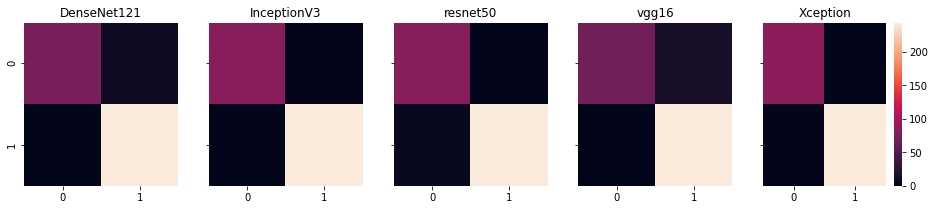

In [ ]:
fig, axn = plt.subplots(1,5, sharex=True, sharey=True,figsize=(16,3))
for i, ax in enumerate(axn.flat):
    sns.heatmap(cf_matrix[i], ax=ax,cbar=i==4)
    ax.set_title(name_models[i],fontsize=12)

## Generando un modelo de ensamblaje con los modelos obtenidos

In [ ]:
X = df_prediccionesF.drop(['label', 'Name_files'], axis = 1)
y = df_prediccionesF['label']

In [ ]:
from sklearn.model_selection import train_test_split
random_seed1 = 1  # para reproducibilidad
np.random.seed(random_seed1)
shuffle1 = True  # reordenar la data aleatoriamente
test_size1 = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size1,random_state=random_seed1)

a) support vector machine

In [ ]:
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model_SVML= SVC(C=0.5, kernel='linear')
clf = model_SVML.fit(X_train, y_train)
y_pred = model_SVML.predict(X_test) 

print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  1.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('')
print('Classification Report')
target_names = ['covid', 'normal']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[76  0]
 [ 0 23]]

Classification Report
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        76
      normal       1.00      1.00      1.00        23

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



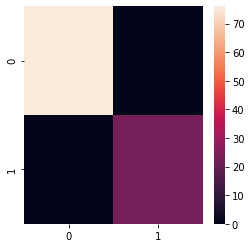

In [ ]:
fig, axn = plt.subplots(1,1, sharex=True, sharey=True,figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, y_pred), cbar=i==4)


In [ ]:
especificidadA=[]
sensibilidadA=[]
exactitudA=[]
puntajeF1A=[]
PrecisionA=[]

In [ ]:
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn+fp)
  especificidadA.append(specificity)
  print("Specificity: ",specificity)
  print("")
  sensivity = tp / (tp+fn)
  sensibilidadA.append(sensivity)
  print("Sensivity: ",sensivity)
  print("")
  accuracyT = (tp+tn)/ (tn+fp+fn+tp)
  exactitudA.append(accuracyT)
  print("Accuracy: ",accuracyT)
  print("")
  F1score = 2*tp/ (2*tp+fp+fn)
  puntajeF1A.append(F1score)
  print("F1 score: ",F1score)
  print("")
  precision = tp/ (tp+fp)
  PrecisionA.append(precision)
  print("Precision (PPV): ",precision)
  print("")

Specificity:  1.0

Sensivity:  1.0

Accuracy:  1.0

F1 score:  1.0

Precision (PPV):  1.0



## Generando un modelo de ensamblaje con los resultados de los modelos de severity

In [ ]:
dfE = pd.read_csv('./Data_assemble.csv', sep = ',')
dfE

,DenseNet121,InceptionV3,resnet50,vgg16,Xception,covid,no_covid,normal,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Lung Lesion,Fracture,Lung Opacity,Enlarged Cardiomediastinum,label,Files
0,0.999987,0.999319,0.990922,0.999825,9.999507e-01,9.999988e-01,0.000001,1.560950e-17,-0.898153,-1.528037,-1.488220,-2.731157,-1.995956,-3.218217,-2.418211,-0.439251,-0.966546,-1.719939,-1.383447,-2.476379,-1.612077,-3.367118,-2.293882,-2.302237,0.064566,-1.229870,1,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
1,0.999969,0.993037,0.956149,0.986412,9.999846e-01,9.052315e-01,0.094203,5.653500e-04,-1.074222,-1.540874,-1.667827,-2.379224,-2.050037,-3.203965,-2.245784,-0.538897,-1.633958,-1.529358,-1.397597,-2.373109,-1.368522,-3.899109,-2.209975,-2.423493,0.069938,-1.014072,1,1-s2.0-S0929664620300449-gr2_lrg-b.jpg
2,0.998071,0.997409,0.617267,0.980603,9.999541e-01,9.997731e-01,0.000227,3.004280e-10,-0.999739,-1.523765,-1.685748,-2.577439,-1.975441,-3.279730,-2.466789,-0.556927,-1.407813,-1.813915,-1.529294,-2.501138,-1.647201,-3.958587,-2.451236,-2.378292,0.069895,-1.232419,1,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
3,0.996132,0.951078,0.983579,0.997754,9.932605e-01,9.906478e-01,0.009348,4.196990e-06,-0.991409,-1.522888,-1.627334,-2.446718,-1.953229,-3.085541,-2.396809,-0.550508,-1.258095,-1.608562,-1.362503,-2.469810,-1.524294,-3.741683,-2.310434,-2.379141,0.022615,-1.111726,1,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
4,0.999975,0.978173,0.993932,0.996228,9.999995e-01,9.993554e-01,0.000645,5.356530e-09,-1.282297,-1.718355,-1.646121,-2.484178,-2.099698,-3.332868,-2.441772,-0.749141,-1.493087,-1.409327,-1.123569,-2.315745,-1.058572,-2.636508,-2.276667,-2.473757,-0.211983,-1.088172,1,16660_3_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.000061,0.000516,0.051705,0.000088,9.298320e-05,1.953400e-14,0.205293,7.947068e-01,-1.376482,-2.024940,-2.269975,-3.282334,-2.718274,-3.218816,-3.841248,-1.718286,-0.962081,-2.678978,-2.308629,-2.733453,-2.085305,-5.228038,-4.613498,-2.931912,0.269786,-1.584514,0,NORMAL2-IM-0983-0001.jpeg
326,0.000145,0.000002,0.018885,0.000005,2.086160e-05,3.697490e-29,0.069771,9.302290e-01,-1.700940,-2.141774,-2.503841,-3.857741,-2.768699,-3.602586,-4.436375,-2.279779,-1.081043,-3.322143,-2.331124,-2.864315,-2.368350,-6.051805,-5.020579,-3.206001,0.345504,-1.630950,0,NORMAL2-IM-0986-0001.jpeg
327,0.000076,0.000000,0.036638,0.000003,8.940700e-07,0.000000e+00,0.017366,9.826344e-01,-1.125800,-1.734239,-1.840421,-2.963732,-2.248300,-3.279679,-2.895475,-0.907544,-0.925345,-2.205725,-1.889415,-2.492562,-1.801513,-4.590178,-3.559200,-2.656400,0.452869,-1.405240,0,NORMAL2-IM-0987-0001.jpeg
328,0.000014,0.000000,0.040013,0.000007,2.980230e-07,2.945580e-25,0.093127,9.068735e-01,-1.634963,-1.942654,-2.168409,-3.429904,-2.753971,-3.516518,-3.545671,-1.689775,-0.930255,-2.979134,-2.508066,-2.590662,-2.028324,-5.916594,-4.652284,-3.160109,0.680091,-1.550569,0,NORMAL2-IM-0989-0001.jpeg


__Trabajando solo con la data de severidad__

In [ ]:
dfP=dfE

In [ ]:
dfP.drop(dfE.iloc[:, 0:8], inplace = True, axis = 1)

In [ ]:
dfP

,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Lung Lesion,Fracture,Lung Opacity,Enlarged Cardiomediastinum,label,Files
0,-0.898153,-1.528037,-1.488220,-2.731157,-1.995956,-3.218217,-2.418211,-0.439251,-0.966546,-1.719939,-1.383447,-2.476379,-1.612077,-3.367118,-2.293882,-2.302237,0.064566,-1.229870,1,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
1,-1.074222,-1.540874,-1.667827,-2.379224,-2.050037,-3.203965,-2.245784,-0.538897,-1.633958,-1.529358,-1.397597,-2.373109,-1.368522,-3.899109,-2.209975,-2.423493,0.069938,-1.014072,1,1-s2.0-S0929664620300449-gr2_lrg-b.jpg
2,-0.999739,-1.523765,-1.685748,-2.577439,-1.975441,-3.279730,-2.466789,-0.556927,-1.407813,-1.813915,-1.529294,-2.501138,-1.647201,-3.958587,-2.451236,-2.378292,0.069895,-1.232419,1,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
3,-0.991409,-1.522888,-1.627334,-2.446718,-1.953229,-3.085541,-2.396809,-0.550508,-1.258095,-1.608562,-1.362503,-2.469810,-1.524294,-3.741683,-2.310434,-2.379141,0.022615,-1.111726,1,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
4,-1.282297,-1.718355,-1.646121,-2.484178,-2.099698,-3.332868,-2.441772,-0.749141,-1.493087,-1.409327,-1.123569,-2.315745,-1.058572,-2.636508,-2.276667,-2.473757,-0.211983,-1.088172,1,16660_3_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,-1.376482,-2.024940,-2.269975,-3.282334,-2.718274,-3.218816,-3.841248,-1.718286,-0.962081,-2.678978,-2.308629,-2.733453,-2.085305,-5.228038,-4.613498,-2.931912,0.269786,-1.584514,0,NORMAL2-IM-0983-0001.jpeg
326,-1.700940,-2.141774,-2.503841,-3.857741,-2.768699,-3.602586,-4.436375,-2.279779,-1.081043,-3.322143,-2.331124,-2.864315,-2.368350,-6.051805,-5.020579,-3.206001,0.345504,-1.630950,0,NORMAL2-IM-0986-0001.jpeg
327,-1.125800,-1.734239,-1.840421,-2.963732,-2.248300,-3.279679,-2.895475,-0.907544,-0.925345,-2.205725,-1.889415,-2.492562,-1.801513,-4.590178,-3.559200,-2.656400,0.452869,-1.405240,0,NORMAL2-IM-0987-0001.jpeg
328,-1.634963,-1.942654,-2.168409,-3.429904,-2.753971,-3.516518,-3.545671,-1.689775,-0.930255,-2.979134,-2.508066,-2.590662,-2.028324,-5.916594,-4.652284,-3.160109,0.680091,-1.550569,0,NORMAL2-IM-0989-0001.jpeg


In [ ]:
X = dfP.drop(['label', 'Files'], axis = 1)
y = dfP['label']

In [ ]:
from sklearn.model_selection import train_test_split
random_seed1 = 1  # para reproducibilidad
np.random.seed(random_seed1)
shuffle1 = True  # reordenar la data aleatoriamente
test_size1 = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size1,random_state=random_seed1)

In [ ]:
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model_SVML= SVC(C=0.5, kernel='linear')
clf = model_SVML.fit(X_train, y_train)
y_pred = model_SVML.predict(X_test) 

print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.9696969696969697


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('')
print('Classification Report')
target_names = ['covid', 'normal']
print(classification_report(y_test, y_pred, target_names=target_names))


Confusion Matrix
[[74  2]
 [ 1 22]]

Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.97      0.98        76
      normal       0.92      0.96      0.94        23

    accuracy                           0.97        99
   macro avg       0.95      0.97      0.96        99
weighted avg       0.97      0.97      0.97        99



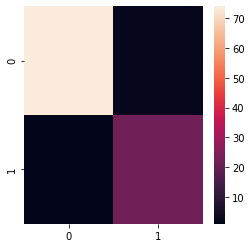

In [ ]:
fig, axn = plt.subplots(1,1, sharex=True, sharey=True,figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, y_pred), cbar=4)

In [ ]:
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn+fp)
  especificidadA.append(specificity)
  print("Specificity: ",specificity)
  print("")
  sensivity = tp / (tp+fn)
  sensibilidadA.append(sensivity)
  print("Sensivity: ",sensivity)
  print("")
  accuracyT = (tp+tn)/ (tn+fp+fn+tp)
  exactitudA.append(accuracyT)
  print("Accuracy: ",accuracyT)
  print("")
  F1score = 2*tp/ (2*tp+fp+fn)
  puntajeF1A.append(F1score)
  print("F1 score: ",F1score)
  print("")
  precision = tp/ (tp+fp)
  PrecisionA.append(precision)
  print("Precision (PPV): ",precision)
  print("")

Specificity:  0.9736842105263158

Sensivity:  0.9565217391304348

Accuracy:  0.9696969696969697

F1 score:  0.9361702127659575

Precision (PPV):  0.9166666666666666



__Trabajando con la data conjunta__

In [ ]:
dfE

,DenseNet121,InceptionV3,resnet50,vgg16,Xception,covid,no_covid,normal,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Lung Lesion,Fracture,Lung Opacity,Enlarged Cardiomediastinum,label,Files
0,0.999987,0.999319,0.990922,0.999825,9.999507e-01,9.999988e-01,0.000001,1.560950e-17,-0.898153,-1.528037,-1.488220,-2.731157,-1.995956,-3.218217,-2.418211,-0.439251,-0.966546,-1.719939,-1.383447,-2.476379,-1.612077,-3.367118,-2.293882,-2.302237,0.064566,-1.229870,1,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
1,0.999969,0.993037,0.956149,0.986412,9.999846e-01,9.052315e-01,0.094203,5.653500e-04,-1.074222,-1.540874,-1.667827,-2.379224,-2.050037,-3.203965,-2.245784,-0.538897,-1.633958,-1.529358,-1.397597,-2.373109,-1.368522,-3.899109,-2.209975,-2.423493,0.069938,-1.014072,1,1-s2.0-S0929664620300449-gr2_lrg-b.jpg
2,0.998071,0.997409,0.617267,0.980603,9.999541e-01,9.997731e-01,0.000227,3.004280e-10,-0.999739,-1.523765,-1.685748,-2.577439,-1.975441,-3.279730,-2.466789,-0.556927,-1.407813,-1.813915,-1.529294,-2.501138,-1.647201,-3.958587,-2.451236,-2.378292,0.069895,-1.232419,1,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
3,0.996132,0.951078,0.983579,0.997754,9.932605e-01,9.906478e-01,0.009348,4.196990e-06,-0.991409,-1.522888,-1.627334,-2.446718,-1.953229,-3.085541,-2.396809,-0.550508,-1.258095,-1.608562,-1.362503,-2.469810,-1.524294,-3.741683,-2.310434,-2.379141,0.022615,-1.111726,1,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
4,0.999975,0.978173,0.993932,0.996228,9.999995e-01,9.993554e-01,0.000645,5.356530e-09,-1.282297,-1.718355,-1.646121,-2.484178,-2.099698,-3.332868,-2.441772,-0.749141,-1.493087,-1.409327,-1.123569,-2.315745,-1.058572,-2.636508,-2.276667,-2.473757,-0.211983,-1.088172,1,16660_3_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.000061,0.000516,0.051705,0.000088,9.298320e-05,1.953400e-14,0.205293,7.947068e-01,-1.376482,-2.024940,-2.269975,-3.282334,-2.718274,-3.218816,-3.841248,-1.718286,-0.962081,-2.678978,-2.308629,-2.733453,-2.085305,-5.228038,-4.613498,-2.931912,0.269786,-1.584514,0,NORMAL2-IM-0983-0001.jpeg
326,0.000145,0.000002,0.018885,0.000005,2.086160e-05,3.697490e-29,0.069771,9.302290e-01,-1.700940,-2.141774,-2.503841,-3.857741,-2.768699,-3.602586,-4.436375,-2.279779,-1.081043,-3.322143,-2.331124,-2.864315,-2.368350,-6.051805,-5.020579,-3.206001,0.345504,-1.630950,0,NORMAL2-IM-0986-0001.jpeg
327,0.000076,0.000000,0.036638,0.000003,8.940700e-07,0.000000e+00,0.017366,9.826344e-01,-1.125800,-1.734239,-1.840421,-2.963732,-2.248300,-3.279679,-2.895475,-0.907544,-0.925345,-2.205725,-1.889415,-2.492562,-1.801513,-4.590178,-3.559200,-2.656400,0.452869,-1.405240,0,NORMAL2-IM-0987-0001.jpeg
328,0.000014,0.000000,0.040013,0.000007,2.980230e-07,2.945580e-25,0.093127,9.068735e-01,-1.634963,-1.942654,-2.168409,-3.429904,-2.753971,-3.516518,-3.545671,-1.689775,-0.930255,-2.979134,-2.508066,-2.590662,-2.028324,-5.916594,-4.652284,-3.160109,0.680091,-1.550569,0,NORMAL2-IM-0989-0001.jpeg


In [ ]:
X = dfE.drop(['label', 'Files', 'no_covid', 'normal'], axis = 1)
y = dfE['label']

In [ ]:
from sklearn.model_selection import train_test_split
random_seed1 = 1  # para reproducibilidad
np.random.seed(random_seed1)
shuffle1 = True  # reordenar la data aleatoriamente
test_size1 = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size1,random_state=random_seed1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('')
print('Classification Report')
target_names = ['covid', 'normal']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[74  2]
 [ 1 22]]

Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.97      0.98        76
      normal       0.92      0.96      0.94        23

    accuracy                           0.97        99
   macro avg       0.95      0.97      0.96        99
weighted avg       0.97      0.97      0.97        99



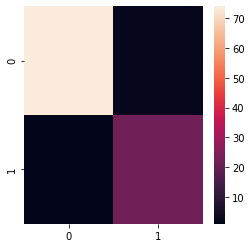

In [ ]:
fig, axn = plt.subplots(1,1, sharex=True, sharey=True,figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, y_pred), cbar=i==4)

In [ ]:
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn+fp)
  especificidadA.append(specificity)
  print("Specificity: ",specificity)
  print("")
  sensivity = tp / (tp+fn)
  sensibilidadA.append(sensivity)
  print("Sensivity: ",sensivity)
  print("")
  accuracyT = (tp+tn)/ (tn+fp+fn+tp)
  exactitudA.append(accuracyT)
  print("Accuracy: ",accuracyT)
  print("")
  F1score = 2*tp/ (2*tp+fp+fn)
  puntajeF1A.append(F1score)
  print("F1 score: ",F1score)
  print("")
  precision = tp/ (tp+fp)
  PrecisionA.append(precision)
  print("Precision (PPV): ",precision)
  print("")

Specificity:  0.9736842105263158

Sensivity:  0.9565217391304348

Accuracy:  0.9696969696969697

F1 score:  0.9361702127659575

Precision (PPV):  0.9166666666666666



__Resumiendo los resultados__

In [ ]:
Analisis=["Binary models", "Severity models","All models"]
df_analisis = pd.DataFrame(list(zip(Analisis, especificidadA, sensibilidadA, exactitudA, puntajeF1A, PrecisionA)),
               columns =['Models', 'Specificity', 'Sensivity', 'Accuracy', 'F1 score', 'Precision (PPV)'])
df_analisis

,Models,Specificity,Sensivity,Accuracy,F1 score,Precision (PPV)
0,Binary models,1.000000,1.000000,1.000000,1.00000,1.000000
1,Severity models,0.973684,0.956522,0.969697,0.93617,0.916667
2,All models,0.973684,0.956522,0.969697,0.93617,0.916667


In [ ]:
df_analisis.to_csv('Models_Assembly_SVM_Results.csv', index=False)